### Cats vs Dogs partial - CNN
- 부분 데이터 : 고양이: 1000(train) + 500(test), 개: 1000 + 500

In [19]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# wget 원격지에 있는 파일 다운로드

--2023-11-08 06:06:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.207, 173.194.193.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   117MB/s    in 0.6s    

2023-11-08 06:06:30 (117 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [20]:
!rm -rf cats_and_dogs_filtered      # dir 제거

In [21]:
!unzip cats_and_dogs_filtered.zip > /dev/null   # /dev/null output 안나옴

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 탐색

In [23]:
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [24]:
# 파일의 갯수
import os

for dir in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    fnames = os.listdir(dir)
    print(f'{dir}: {len(fnames):,d}')

cats_and_dogs_filtered/train/cats: 1,000
cats_and_dogs_filtered/train/dogs: 1,000
cats_and_dogs_filtered/validation/cats: 500
cats_and_dogs_filtered/validation/dogs: 500


- 이미지 확인

In [25]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

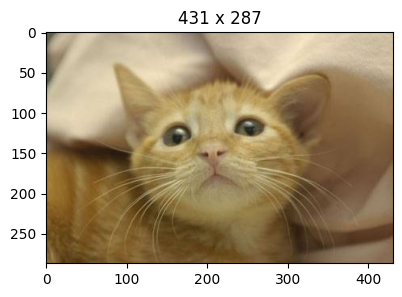

In [26]:
# 1) Pillow Image
from PIL import Image
img = Image.open(fname)
plt.figure(figsize=(5,3))
plt.title(f'{img.width} x {img.height}')
plt.imshow(img);

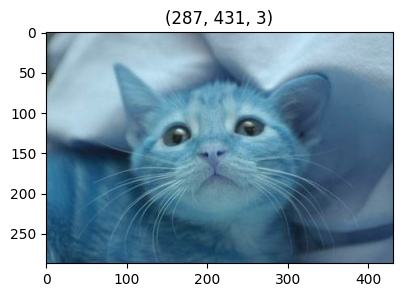

In [27]:
# 2) OpenCV image: 순서가 RGB가 아니고 BGR
import cv2
img2 = cv2.imread(fname)
plt.figure(figsize=(5,3))
plt.title(img2.shape)       # OpenCV로 읽으면 numpy ndarray로 읽힘 > np.shape임
plt.imshow(img2);

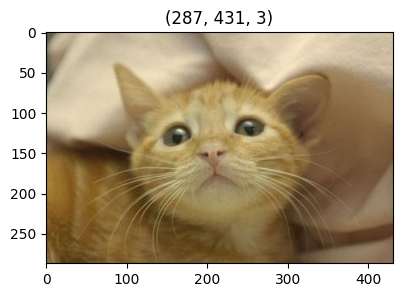

In [28]:
img2 = cv2.imread(fname)
plt.figure(figsize=(5,3))
plt.title(img2.shape)       # OpenCV로 읽으면 numpy ndarray로 읽힘 > np.shape임
plt.imshow(img2[:,:,::-1]); # [세로, 가로, gbr을 거꾸로]

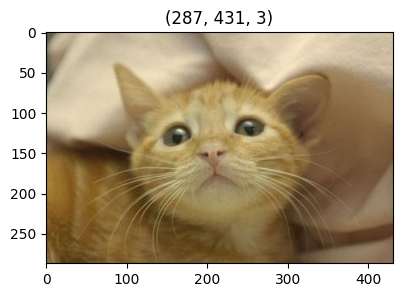

In [29]:
plt.figure(figsize=(5,3))
plt.title(img2.shape)
img3 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
plt.imshow(img3);

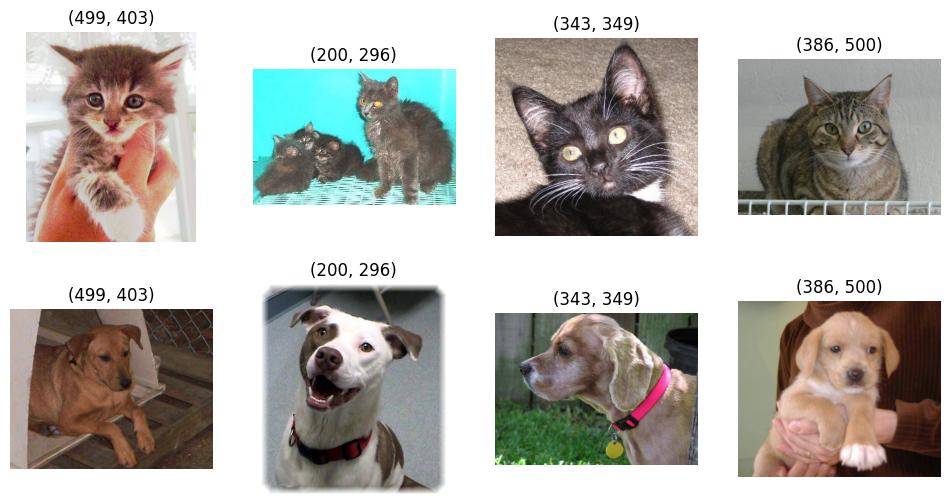

In [30]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(f'{train_cats_dir}/cat.10{i}.jpg')[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(f'{train_dogs_dir}/dog.10{i}.jpg')[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(cat.shape[:-1])
plt.show()

- 모델 구성

In [31]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [32]:
# input_shape이 다 다름 > (150, 150, 3)으로 잡음 > keras 이미지 축소 사용
model = Sequential([
    # 이미지를 150x150의 크기로 변환해주는 무언가가 필요하다
    Conv2D(16, (3,3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

In [33]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model_path = 'best-cats-and-dogs.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

- 파일에서 이미지 데이터를 읽어서 학습시키는 방법

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [35]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

# dog : 1, cat: 0하고 이미지까지 150,150으로 사이즈 변경까지
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)
# binary : 고양이, 개 이진분류
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 모델 학습

In [36]:
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    # batch_size(20) from train_generator x steps_per_epoch(100) = 2000, 트레인 데이터가 2,000개
    steps_per_epoch=100,
    # batch_size(20) from test_generator x validation_step(50) = 1000, 테스트 데이터가 1,000개
    validation_steps=50,
    callbacks=[mc, es]
)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.7031 - accuracy: 0.5747
Epoch 1: val_loss improved from inf to 0.68800, saving model to best-cats-and-dogs.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 18s 55ms/step - loss: 0.7022 - accuracy: 0.5760 - val_loss: 0.6880 - val_accuracy: 0.6030
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.6783
Epoch 2: val_loss improved from 0.68800 to 0.58603, saving model to best-cats-and-dogs.h5
100/100 [==============================] - 7s 65ms/step - loss: 0.6148 - accuracy: 0.6780 - val_loss: 0.5860 - val_accuracy: 0.7070
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5418 - accuracy: 0.7343
Epoch 3: val_loss improved from 0.58603 to 0.54555, saving model to best-cats-and-dogs.h5
100/100 [==============================] - 5s 54ms/step - loss: 0.5423 - accuracy: 0.7340 - val_loss: 0.5456 - val_accuracy: 0.7300
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4842 - accuracy: 0.7682
Epoch 4: val_loss improved from 0.54555 to 0.54212, saving model to best-cats-and-dogs.h5
100/100 [==============================] -

In [37]:
best_model = load_model(model_path)
best_model.evaluate(test_generator)

50/50 [==============================] - 2s 32ms/step - loss: 0.5421 - accuracy: 0.7330


[0.5421184301376343, 0.7329999804496765]

- 테스트 이미지 분류

In [69]:
from google.colab import files

up = files.upload()

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.png to cat3.png
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg


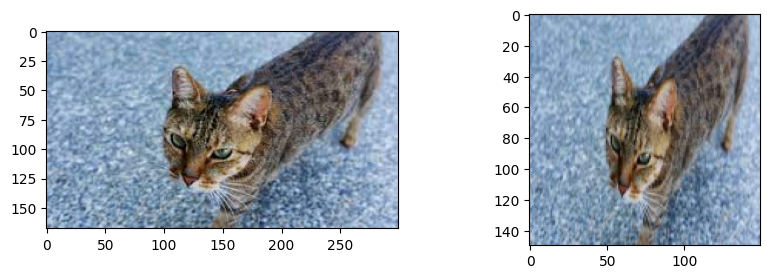

In [70]:
img = cv2.imread('cat2.jpg')[:, :, ::-1]
img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [71]:
best_model.predict(img2.reshape(-1,150,150,3))

1/1 [==============================] - 0s 19ms/step


array([[1.]], dtype=float32)

In [72]:
for fname in up.keys(): # dict.keys()
    img = cv2.imread(fname)[:,:,::-1]
    img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    # best_model이 4차원이여서 맞춰줌 (2000, 150, 150, 3) / (1, 150,150,3)도 가능
    classes = best_model.predict(img2.reshape(-1,150,150,3), verbose=0)
    print(f"{classes[0,0]:.4f} {fname} is {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0000 cat1.jpg is cat
1.0000 cat2.jpg is dog
0.0000 cat3.png is cat
1.0000 dog1.jpg is dog
1.0000 dog2.jpg is dog
1.0000 dog3.jpg is dog


In [73]:
!rm cat?.* dog*